In [1]:
import os, sys, pathlib

REPO_URL = "https://github.com/UmerSR/Connect-Four-RL.git"
WORKSPACE = "/content/Connect-Four-RL"

if not os.path.exists(WORKSPACE):
    !git clone $REPO_URL $WORKSPACE
else:
    %cd $WORKSPACE
    !git pull --ff-only

%cd $WORKSPACE/rl_connect4
sys.path.insert(0, WORKSPACE)
print("CWD:", os.getcwd())


Cloning into '/content/Connect-Four-RL'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 166 (delta 33), reused 57 (delta 16), pack-reused 87 (from 1)
Receiving objects: 100% (166/166), 62.47 MiB | 50.93 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/Connect-Four-RL/rl_connect4
CWD: /content/Connect-Four-RL/rl_connect4


In [2]:
!pip install -q stable-baselines3[extra] sb3-contrib gymnasium pygame numpy torch pandas matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0

In [3]:
import os
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import Dict, Tuple

from envs.connect_four_env import ConnectFourEnv
from agents.opponents import get_opponent

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", DEVICE)

# detect if running inside the cloned repo (Colab will place us in /content/Connect-Four-RL/rl_connect4)
HERE = Path.cwd()
ROOT = HERE if (HERE / 'artifacts').exists() else HERE.parent
ARTIFACTS = ROOT / 'artifacts'
MODEL_PATHS = {
    'PPO': ARTIFACTS / 'ppo' / 'ppo.pth',
    'PPO Pool': ARTIFACTS / 'ppo' / 'ppo_pool.pth',
    'PPO Dense': ARTIFACTS / 'ppo' / 'ppo_dense.pth',
    'DQN': ARTIFACTS / 'dqn' / 'dqn_connect4.pth',
    'REINFORCE Manual': ARTIFACTS / 'reinforce_manual' / 'reinforce_connect4.pth',
    'REINFORCE TS': ARTIFACTS / 'reinforce_tianshou' / 'reinforce_connect4.pth',
}

KIND_MAP = {
    'PPO': 'ppo',
    'PPO Pool': 'ppo_pool',
    'PPO Dense': 'ppo_dense',
    'DQN': 'dqn',
    'REINFORCE Manual': 'reinforce_manual',
    'REINFORCE TS': 'reinforce_tianshou',
}

print("Artifact root:", ARTIFACTS.resolve())
missing = []
for name, path in MODEL_PATHS.items():
    if not path.exists():
        missing.append((name, path))
if missing:
    for name, path in missing:
        print(f"Warning: missing model for {name}: {path}")
else:
    print("All model files found.")


2025-12-17 17:21:58.004405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765992118.206173      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765992118.262311      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Running on: cuda
Artifact root: /content/Connect-Four-RL/artifacts
All model files found.


In [4]:
def load_agents(device=DEVICE):
    agents = {}
    for name, path in MODEL_PATHS.items():
        kind = KIND_MAP[name]
        agents[name] = get_opponent(kind, model_path=path, device=device)
        
        guided_name = "guided_" + name
        guided_kind = "guided_" + kind
        agents[guided_name] = get_opponent(guided_kind, model_path=path, device=device)
    return agents

def resolve_winner(agent_a_is_player1, winner_side):
    # winner_side: 1 or 2 (player number)
    if winner_side == 1 and agent_a_is_player1:
        return 'A'
    if winner_side == 2 and (not agent_a_is_player1):
        return 'A'
    return 'B'

def play_single_game(agent_a, agent_b, agent_a_is_player1=True, seed=None, random_starts=2):
    env = ConnectFourEnv()
    if seed is not None:
        env.reset(seed=seed)
    else:
        env.reset()
        
    done = False
    last_actor = None
    
    # --- STOCHASTICITY FIX: Random Opening ---
    # Plays 'random_starts' moves randomly to force diverse game states
    for _ in range(random_starts):
        if done: break
        # Try to get valid moves from env, fallback to column check if method missing
        if hasattr(env, 'get_valid_moves'):
            valid = env.get_valid_moves()
        else:
            # Fallback for standard board representation
            valid = [c for c in range(7) if env.board[0][c] == 0]
            
        if not valid: break
        
        # Play random move
        action = random.choice(valid)
        # Note: We don't care about reward here, just advancing state
        # Handle different step return signatures (4 or 5 values)
        step_result = env.step(action)
        if len(step_result) == 5:
            _, _, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            _, _, done, _ = step_result
            
    # --- MAIN GAME LOOP ---
    while not done:
        # Determine who acts. 
        # Note: env.current_player is usually 0 or 1.
        # We need to map this to agent_a or agent_b.
        
        # If agent_a is P1 (ID 0), they act when current_player == 0
        current_player_id = env.current_player if hasattr(env, 'current_player') else 0
        
        if agent_a_is_player1:
            actor = agent_a if current_player_id == 0 else agent_b
        else:
            actor = agent_b if current_player_id == 0 else agent_a

        # Select Action
        # Try to pass stochastic flag if supported, otherwise default
        try:
            action = actor.select_action(env, deterministic=False) 
        except:
            action = actor.select_action(env)

        # Step
        step_result = env.step(action)
        if len(step_result) == 5:
            _, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        else:
            _, reward, done, info = step_result
            truncated = False

        # Identify who made this move (1 or 2 for player ID)
        last_actor = 1 if current_player_id == 0 else 2

    # --- RESOLVE WINNER ---
    # Adapt this to your specific env's reward structure (1.0 vs 40.0)
    # Check for simple win signal (> 0)
    if reward > 0 and not info.get('illegal_move'):
        # The actor who just moved (last_actor) won
        winner_side = last_actor
        return resolve_winner(agent_a_is_player1, winner_side)
    
    # Check for illegal move loss
    if info.get('illegal_move'):
        # The actor who just moved lost
        winner_side = 2 if last_actor == 1 else 1
        return resolve_winner(agent_a_is_player1, winner_side)

    return 'D'

def play_series(agent_a, agent_b, n_games=50, seed=42):
    rng = random.Random(seed)
    a_wins = 0
    b_wins = 0
    draws = 0
    
    print(f"  Playing {n_games} games...", end="\r")
    
    for i in range(n_games):
        agent_a_is_p1 = (i % 2 == 0)
        
        # Add small randomness to openings to test robustness
        # 2 moves = 1 random move each. 
        result = play_single_game(
            agent_a, 
            agent_b, 
            agent_a_is_p1, 
            seed=rng.randint(0, 1_000_000),
            random_starts=2 # <--- This adds the stochasticity
        )
        
        if result == 'A':
            a_wins += 1
        elif result == 'B':
            b_wins += 1
        else:
            draws += 1
            
    return {
        'a_wins': a_wins,
        'b_wins': b_wins,
        'draws': draws,
        'total': n_games,
        'a_win_rate': a_wins / n_games,
        'b_win_rate': b_wins / n_games,
        'draw_rate': draws / n_games,
    }

In [5]:
agents = load_agents()
agent_names = list(agents.keys())
results = []

n_games = 100  # per matchup (20 as P1, 20 as P2)
for i, name_a in enumerate(agent_names):
    for j, name_b in enumerate(agent_names):
        if i == j:
            continue
        stats = play_series(agents[name_a], agents[name_b], n_games=n_games)
        results.append({
            'agent_a': name_a,
            'agent_b': name_b,
            **stats,
        })
        print(f"{name_a} vs {name_b}: A win {stats['a_win_rate']*100:.1f}%, B win {stats['b_win_rate']*100:.1f}%, Draw {stats['draw_rate']*100:.1f}%")

results_df = pd.DataFrame(results)
results_df


ppo <class 'str'>
guided_ppo <class 'str'>
ppo_pool <class 'str'>
guided_ppo_pool <class 'str'>
ppo_dense <class 'str'>
guided_ppo_dense <class 'str'>
dqn <class 'str'>
guided_dqn <class 'str'>
reinforce_manual <class 'str'>
guided_reinforce_manual <class 'str'>
reinforce_tianshou <class 'str'>
guided_reinforce_tianshou <class 'str'>
PPO vs guided_PPO: A win 0.0%, B win 100.0%, Draw 0.0%
PPO vs PPO Pool: A win 50.0%, B win 50.0%, Draw 0.0%
PPO vs guided_PPO Pool: A win 0.0%, B win 100.0%, Draw 0.0%
PPO vs PPO Dense: A win 54.0%, B win 46.0%, Draw 0.0%
PPO vs guided_PPO Dense: A win 0.0%, B win 100.0%, Draw 0.0%
PPO vs DQN: A win 94.0%, B win 6.0%, Draw 0.0%
PPO vs guided_DQN: A win 0.0%, B win 100.0%, Draw 0.0%
PPO vs REINFORCE Manual: A win 52.0%, B win 48.0%, Draw 0.0%
PPO vs guided_REINFORCE Manual: A win 0.0%, B win 100.0%, Draw 0.0%
PPO vs REINFORCE TS: A win 98.0%, B win 2.0%, Draw 0.0%
PPO vs guided_REINFORCE TS: A win 0.0%, B win 100.0%, Draw 0.0%
guided_PPO vs PPO: A win 100.0

,agent_a,agent_b,a_wins,b_wins,draws,total,a_win_rate,b_win_rate,draw_rate
0,PPO,guided_PPO,0,100,0,100,0.00,1.00,0.00
1,PPO,PPO Pool,50,50,0,100,0.50,0.50,0.00
2,PPO,guided_PPO Pool,0,100,0,100,0.00,1.00,0.00
3,PPO,PPO Dense,54,46,0,100,0.54,0.46,0.00
4,PPO,guided_PPO Dense,0,100,0,100,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...
127,guided_REINFORCE TS,DQN,100,0,0,100,1.00,0.00,0.00
128,guided_REINFORCE TS,guided_DQN,77,23,0,100,0.77,0.23,0.00
129,guided_REINFORCE TS,REINFORCE Manual,100,0,0,100,1.00,0.00,0.00
130,guided_REINFORCE TS,guided_REINFORCE Manual,79,21,0,100,0.79,0.21,0.00


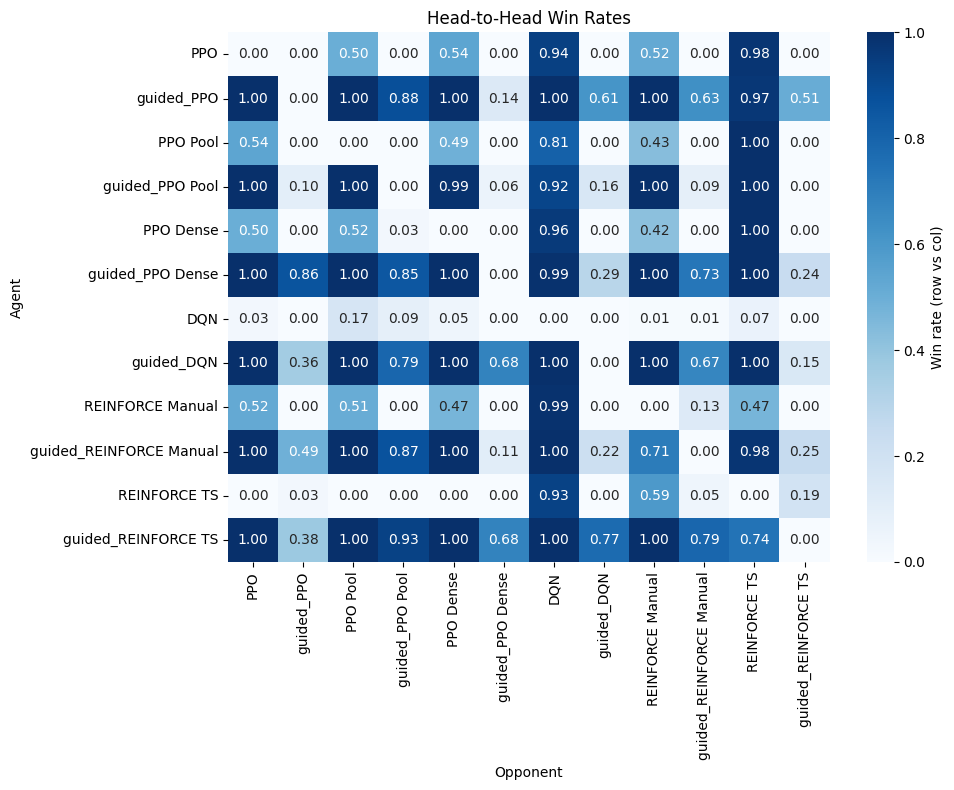

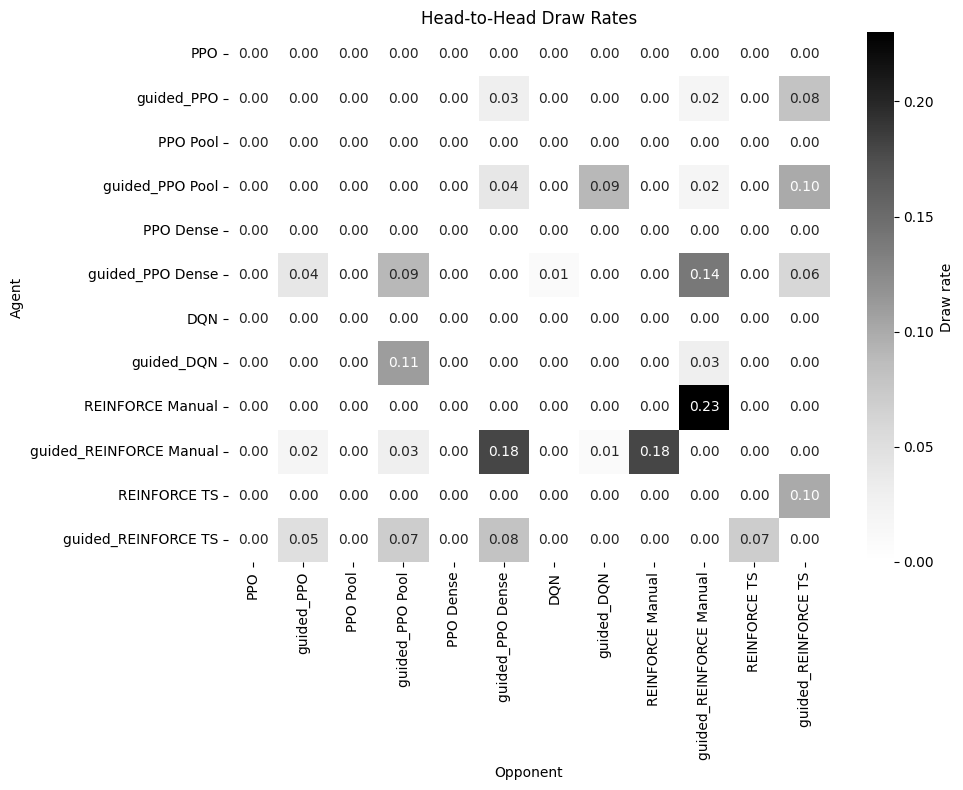

In [6]:
# Build win-rate matrix (rows = agent A, cols = agent B)
win_matrix = pd.DataFrame(0.0, index=agent_names, columns=agent_names)
draw_matrix = pd.DataFrame(0.0, index=agent_names, columns=agent_names)
for _, row in results_df.iterrows():
    a = row['agent_a']; b = row['agent_b']
    win_matrix.loc[a, b] = row['a_win_rate']
    draw_matrix.loc[a, b] = row['draw_rate']

plt.figure(figsize=(10, 8))
sns.heatmap(win_matrix, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Win rate (row vs col)'});
plt.title('Head-to-Head Win Rates'); plt.xlabel('Opponent'); plt.ylabel('Agent'); plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(draw_matrix, annot=True, fmt='.2f', cmap='Greys', cbar_kws={'label': 'Draw rate'});
plt.title('Head-to-Head Draw Rates'); plt.xlabel('Opponent'); plt.ylabel('Agent'); plt.tight_layout(); plt.show()


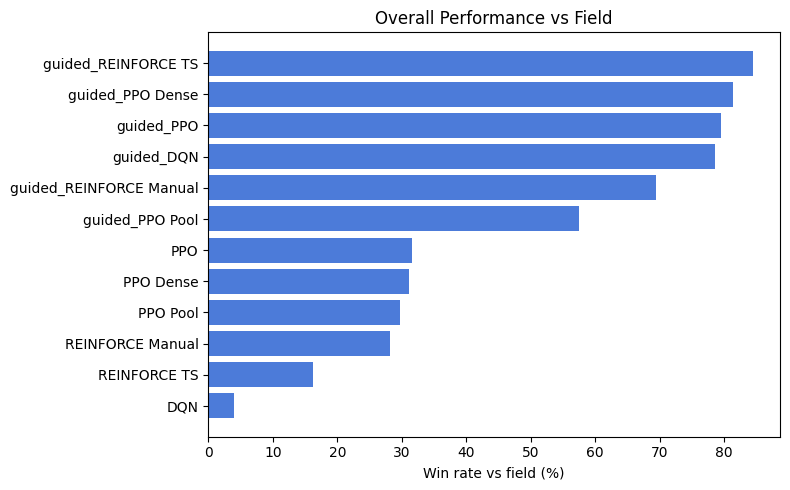

,a_wins,games,win_rate_overall
agent_a,,,
guided_REINFORCE TS,929,1100,0.844545
guided_PPO Dense,896,1100,0.814545
guided_PPO,874,1100,0.794545
guided_DQN,865,1100,0.786364
guided_REINFORCE Manual,763,1100,0.693636
guided_PPO Pool,632,1100,0.574545
PPO,348,1100,0.316364
PPO Dense,343,1100,0.311818
PPO Pool,327,1100,0.297273


In [7]:
# Aggregate leaderboard by average win-rate vs others
agg = results_df.groupby('agent_a')['a_wins'].sum().to_frame()
agg['games'] = results_df.groupby('agent_a')['total'].sum()
agg['win_rate_overall'] = agg['a_wins'] / agg['games']
agg = agg.sort_values('win_rate_overall', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(agg.index, agg['win_rate_overall']*100, color='#4c7bd9');
plt.xlabel('Win rate vs field (%)'); plt.title('Overall Performance vs Field'); plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()

agg


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


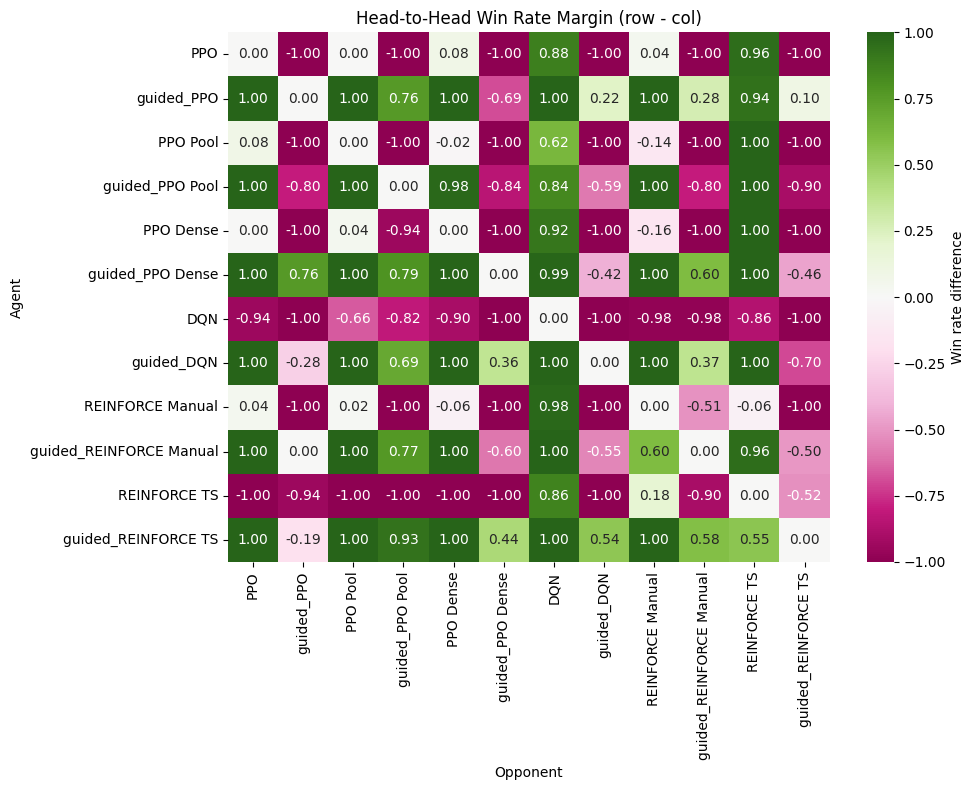

In [8]:
# Per-opponent margin (win - loss)
margin_matrix = pd.DataFrame(0.0, index=agent_names, columns=agent_names)
for _, row in results_df.iterrows():
    a = row['agent_a']; b = row['agent_b']
    margin_matrix.loc[a, b] = row['a_win_rate'] - row['b_win_rate']
plt.figure(figsize=(10, 8))
sns.heatmap(margin_matrix, annot=True, fmt='.2f', center=0, cmap='PiYG', cbar_kws={'label': 'Win rate difference'});
plt.title('Head-to-Head Win Rate Margin (row - col)'); plt.xlabel('Opponent'); plt.ylabel('Agent'); plt.tight_layout(); plt.show()
